<a href="https://colab.research.google.com/github/j3nguyen/user_item_embeddings/blob/master/NextAction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting User Journeys

In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
# import gensim
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel

# spacy for lemmatization
# import spacy

# NLTK for stopwords and stemming
# from nltk.stem.porter import * 
# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')

# Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib

In [0]:
# import nltk
# nltk.download('stopwords')

In [5]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Average, Dropout, Embedding, Activation, TimeDistributed, Concatenate, Flatten, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Read in the data

Rearrange the data so each row is one user and his sequence of actions

In [6]:
df = pd.read_csv("events.csv")

#sort the dataframe by time
df.sort_values(by="timestamp", inplace=True)
df.head()

,timestamp,visitorid,event,itemid,transactionid
1462974,1430622004384,693516,addtocart,297662,NaN
1464806,1430622011289,829044,view,60987,NaN
1463000,1430622013048,652699,view,252860,NaN
1465287,1430622024154,1125936,view,33661,NaN
1462955,1430622026228,693516,view,297662,NaN


In [7]:
# get all the visitor_ids
visitor_ids = df.visitorid.unique()

print("There are {} users".format(len(visitor_ids)))

There are 1407580 users


In [8]:
# inspect action distribution
df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [0]:
# encode actions to numbers
action_to_idx = {"view": 0, "addtocart": 1, "transaction": 2}

In [0]:
# creating dictionary of visitor sequence of activity
visitor_activity = {}

for visitor in visitor_ids[:500]:
  # get user's actions in order of time
  actions = df[df.visitorid == visitor].event.values
  
  if len(actions) > 50:
    # get the first 51 actions
    actions = list(map(lambda x: action_to_idx[x],actions)) [:51] 
    visitor_activity[visitor] = actions

In [0]:
hidden_size = 64 #dimension of action vectors
num_actions = len(action_to_idx) #dictionary size
input_length = 50 # number of actions in sequence
num_users = len(visitor_sessions)

#### Create user sessions

Here we're splitting user's actions into 

In [0]:
#30 mins in miliseconds 
session_expire = 60*30*1000

visitor_sessions = {}

for visitor in visitor_ids[:100000]:
    # calculate time deltas between actions
    time_delta = df[df.visitorid == visitor].timestamp.diff()
    actions = df[df.visitorid == visitor].event.values

    if len(actions) > 1:
      # split actions into sessions, where a session ends after session_expire
      all_sessions = np.split(actions,np.where(time_delta >= session_expire)[0])

      # sessions with more than one action
      filtered_sessions = list(filter(lambda x: len(x) > 1, all_sessions))

      if len(filtered_sessions) > 0:
        visitor_sessions[visitor] = list(map(lambda x: list(map(lambda y: action_to_idx[y],x)) ,filtered_sessions))


In [11]:
sum(map(len,visitor_sessions.values()))/len(visitor_sessions)

1.555572839698219

In [12]:
len(visitor_sessions)

25714

In [0]:
import bz2
import pickle

pickle.dump( visitor_sessions, bz2.BZ2File('/content/drive/My Drive/Colab Notebooks/visitor_sessions.pkl', 'w') )

In [0]:
pickle.dump(visitor_activity, bz2.BZ2File('visitor_activity.pkl','w'))

#### Create the training data and labels

Here, we're holding out the 51st action as the label

In [0]:
actions = visitor_activity.values()
d = np.array(range(len(actions))) # users
X = np.array(list(map(lambda x: x[:-1], actions))) #actions for each user
y = to_categorical(np.array(list(map(lambda x: x[50], actions))), num_classes=3) # shift sequence on step forward
X_3d = X.reshape((X.shape[0],X.shape[1],1))

Reformatting the data to one session per row

In [0]:
sessions = visitor_sessions.values()
sessions_flat = [item for sublist in sessions for item in sublist]

In [152]:
len(sessions_flat)

40000

In [151]:
# assigning user_ids to each session
d = [[i]*len(visitor_sessions[user_id]) for i, user_id in zip(range(len(sessions)),visitor_sessions.keys())]
d = np.array([item for sublist in d for item in sublist])

X = np.array(list(map(lambda x: np.array(x[:-1]), sessions_flat)))
y = to_categorical(np.array(list(map(lambda x: x[-1], sessions_flat))),num_classes=3)
print(X.shape)
print(y.shape)

(40000,)
(40000, 3)


In [0]:
from keras.utils import Sequence
class MyBatchGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X, d, y, batch_size=1, shuffle=True):
        'Initialization'
        self.X = X
        self.y = y
        self.d = d
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.y)/self.batch_size))

    def __getitem__(self, index):
        return self.__data_generation(index)

    def on_epoch_end(self):
        'Shuffles indexes after each epoch'
        self.indexes = np.arange(len(self.y))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index):
        Xb = np.empty((self.batch_size, *X[index].shape))
        yb = np.empty((self.batch_size, *y[index].shape))
        db = np.empty((self.batch_size, *d[index].shape))
        # naively use the same sample over and over again
        for s in range(0, self.batch_size):
            Xb[s] = X[index]
            yb[s] = y[index]
            db[s] = d[index]
        return [Xb, db], yb

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, d_train, d_test, y_train, y_test,X_3d_train, X_3d_test = train_test_split(X,d,y,X_3d, test_size = 0.2, random_state=342,stratify=y)

In [0]:
X_train, X_test,d_train, d_test,y_train, y_test = train_test_split(X,d,y, test_size = 0.2, random_state=342,stratify=y)

In [0]:
X_train, X_val,d_train,d_val,y_train, y_val = train_test_split(X_train,d_train,y_train, test_size = 0.2, random_state=342,stratify=y_train)

## Build the models

### Using the Sequential API

In [13]:
#create the LSTM network

# model = Sequential()
# model.add(Embedding(
#     input_dim=num_actions,
#     output_dim=hidden_size, #hidden layer dimension
#     input_length=input_length,
#     trainable=True
#   )
# )

# model.add(LSTM(hidden_size, return_sequences=True))
# model.add(Dropout(rate=0.5))
# model.add(Activation('softmax'))


model = Sequential()
model.add(Embedding(num_actions, hidden_size, input_length=input_length))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=False))

model.add(Dropout(rate=0.5))
# model.add(TimeDistributed(Dense(num_actions)))
# model.add(Activation('softmax'))
model.add(Dense(num_actions, activation='softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Using the Keras functional API

We treat each user action like a word. In this data set, there are three types of actions:


* view
* add to cart
* transaction

Therefore, the size of the vocabulary is 3. A user's sequence of actions, or her journey, is liken to a sentence/paragraph.

We want to embed these actions into vectors as well as the user's journey to help predict the next action. 

#### Model 1
The first model will embed the actions and user's journey to help predict the next action. This is similar to a multi-class classification problem.



In [0]:
## helper functions for doc2vec algorithm
def my_split(window_size):
    def _lambda(tensor):
        import tensorflow as tf
        return tf.split(tensor, window_size + 1, axis=1)
    return _lambda


def squeeze(axis=-1):
    def _lambda(tensor):
        import tensorflow as tf
        return tf.squeeze(tensor, axis=axis)
    return _lambda


def stack(window_size):
    def _lambda(tensor):
        import tensorflow as tf
        return tf.stack([tensor] * window_size, axis=1)
    return _lambda

In [0]:
#Create the LSTM  network using the functional API

# sequence of actions
A = Input(shape=(input_length,), name="actions") #length of sequence, size of vocab

# document ID
U = Input(shape=(1,), name="users")

#create embedding for actions and for users
a = Embedding(input_dim=num_actions, output_dim=hidden_size, input_length=input_length, name='action_embedding')(A) # shape 50,64
u = Embedding(input_dim=num_users, output_dim=hidden_size, input_length=1, name='user_embedding')(U) # shape 1,64

# combine embeddings
x = Concatenate(axis=1)([u,a])

split = Lambda(my_split(input_length))(x)
averaged = Average()(split)
squeezed = Lambda(squeeze(axis=1))(averaged)

predictions = Dense(num_actions, activation='softmax')(squeezed)

model = Model(inputs=[A, U], outputs=predictions)
model.summary()

In [16]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
h = model.fit([X_train,d_train], y_train, epochs=50, batch_size=128, validation_split=0.1, verbose=1)

#### Model 2
The second model is an RNN which will take into account the sequence of actions to predict the next action.

In [39]:
#Create the NN network using the functional API

# sequence of actions
A = Input(shape=(input_length,), name="actions") #length of sequence, size of vocab
# A = Input(shape=None, batch_shape=(1,), name="actions")

# document ID
U = Input(shape=(1,), name="users")

#create embedding for actions and for users
# a = Embedding(input_dim=num_actions, output_dim=hidden_size, name="action_embedding")(A)
a = Embedding(input_dim=num_actions, output_dim=hidden_size, input_length=input_length, name='action_embedding')(A) # shape 50,64
u = Embedding(input_dim=num_users, output_dim=hidden_size, input_length=1, name='user_embedding')(U) # shape 1,64

# combine embeddings
x = Concatenate(axis=1)([u,a])

L = LSTM(hidden_size,return_sequences=False)(x)

predictions = Dense(num_actions, activation='softmax')(L)

model2 = Model(inputs=[A, U], outputs=predictions)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
actions (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        384         users[0][0]                      
__________________________________________________________________________________________________
action_embedding (Embedding)    (None, 50, 64)       192         actions[0][0]                    
____________________________________________________________________________________________

In [0]:
# create the optimizer
opt2 = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
h = model2.fit([X_train,d_train], y_train, epochs=50, batch_size=128, validation_split=0.1, verbose=0)

In [127]:
#Create the NN network using the functional API with return sequences

# sequence of actions
A = Input(shape=(None,), name="actions") #length of sequence, size of vocab

# document ID
U = Input(shape=(1,), name="users")

#create embedding for actions and for users
a = Embedding(input_dim=num_actions, output_dim=hidden_size, name='action_embedding')(A) # shape 50,64
u = Embedding(input_dim=num_users, output_dim=hidden_size, input_length=1, name='user_embedding')(U) # shape 1,64

# combine embeddings
x = Concatenate(axis=1)([u,a])

L = LSTM(hidden_size,return_sequences=False)(x)

predictions = Dense(num_actions, activation='softmax')(L)

model3 = Model(inputs=[A,U], outputs=predictions)
model3.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
actions (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        1645696     users[0][0]                      
__________________________________________________________________________________________________
action_embedding (Embedding)    (None, None, 64)     192         actions[0][0]                    
___________________________________________________________________________________________

In [132]:
# create the optimizer
opt3 = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model3.compile(optimizer=opt3, loss='categorical_crossentropy', metrics=['accuracy'])

h = model3.fit_generator(MyBatchGenerator(X_train,d_train,y_train),validation_data=MyBatchGenerator(X_val,d_val,y_val), epochs=10, verbose=1)

Epoch 1/10
25600/25600 [==============================] - 668s 26ms/step - loss: 0.2266 - acc: 0.9308 - val_loss: 0.1981 - val_acc: 0.9391
Epoch 2/10
25600/25600 [==============================] - 726s 28ms/step - loss: 0.2152 - acc: 0.9332 - val_loss: 0.1963 - val_acc: 0.9389
Epoch 3/10
25600/25600 [==============================] - 749s 29ms/step - loss: 0.2127 - acc: 0.9334 - val_loss: 0.1951 - val_acc: 0.9400
Epoch 4/10
25600/25600 [==============================] - 782s 31ms/step - loss: 0.2111 - acc: 0.9338 - val_loss: 0.1939 - val_acc: 0.9400
Epoch 5/10
20727/25600 [=======================>......] - ETA: 2:20 - loss: 0.2090 - acc: 0.9339Buffered data was truncated after reaching the output size limit.

## Evaluate models

#### helper functions

In [0]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
y_true = np.argmax(y_test,axis=1)

In [0]:
## Model 1 predictions
pred_prob = model.predict([X_test,d_test])
y_pred = np.argmax(pred_prob,axis=1)

In [0]:
## Model 2 predictions
pred_prob2 = model2.predict([X_test,d_test])
y_pred2 = np.argmax(pred_prob2,axis=1)

In [0]:
## Model 3 predictions
pred_prob3 = model3.predict_generator(MyBatchGenerator(X_test,d_test,y_test))
y_pred3 = np.argmax(pred_prob3,axis=1)

Confusion matrix, without normalization
[[140   1   0]
 [  9   0   0]
 [  3   1   0]]


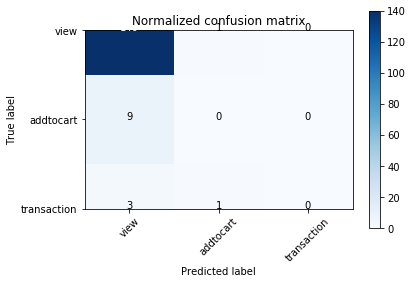

In [26]:
conf=confusion_matrix(y_true,y_pred)
plt.figure()
plot_confusion_matrix(conf, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

Confusion matrix, without normalization
[[139   2   0]
 [  8   1   0]
 [  3   0   1]]


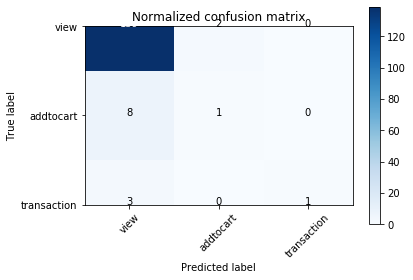

In [27]:
conf2=confusion_matrix(y_true,y_pred2)
plt.figure()
plot_confusion_matrix(conf2, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

Confusion matrix, without normalization
[[7217   13  229]
 [ 311    2    5]
 [ 214    1    8]]


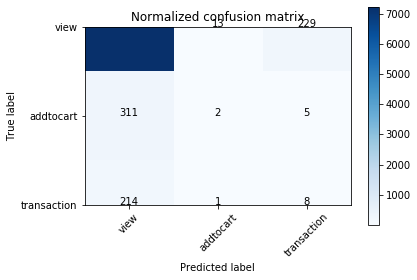

In [135]:
conf3=confusion_matrix(y_true,y_pred3)
plt.figure()
plot_confusion_matrix(conf3, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

In [28]:
print(classification_report(y_true,y_pred,target_names=action_to_idx.keys()))
print(classification_report(y_true,y_pred2,target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.92      0.99      0.96       141
   addtocart       0.00      0.00      0.00         9
 transaction       0.00      0.00      0.00         4

    accuracy                           0.91       154
   macro avg       0.31      0.33      0.32       154
weighted avg       0.84      0.91      0.87       154

              precision    recall  f1-score   support

        view       0.93      0.99      0.96       141
   addtocart       0.33      0.11      0.17         9
 transaction       1.00      0.25      0.40         4

    accuracy                           0.92       154
   macro avg       0.75      0.45      0.51       154
weighted avg       0.89      0.92      0.89       154



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [136]:
print(classification_report(y_true,y_pred3,target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.93      0.97      0.95      7459
   addtocart       0.12      0.01      0.01       318
 transaction       0.03      0.04      0.03       223

    accuracy                           0.90      8000
   macro avg       0.36      0.34      0.33      8000
weighted avg       0.88      0.90      0.89      8000



## Visualize User Journey Embeddings

Get the embeddings from the network

In [0]:
## embeddings for doc2vec model
embeddings = model.get_layer(name='user_embedding')
embeddings = embeddings.get_weights()[0]
embeddings = embeddings / np.linalg.norm(embeddings, axis = 1).reshape((-1, 1))
embeddings = np.nan_to_num(embeddings)

In [0]:
## Embeddings for RNN model
embeddings2 = model2.get_layer(name='user_embedding')
embeddings2 = embeddings2.get_weights()[0]
embeddings2 = embeddings2 / np.linalg.norm(embeddings2, axis = 1).reshape((-1, 1))
embeddings2 = np.nan_to_num(embeddings2)

In [0]:
## Embeddings for variable length RNN model
embeddings3 = model3.get_layer(name='user_embedding')
embeddings3 = embeddings3.get_weights()[0]
embeddings3 = embeddings3 / np.linalg.norm(embeddings3, axis = 1).reshape((-1, 1))
embeddings3 = np.nan_to_num(embeddings3)

### Use tSNE to visualize the embeddings

To visualize each user's vector, we reduce it to two dimensions using tSNE and colour code them with the 51st action

In [0]:
from sklearn.manifold import TSNE


In [139]:
## Embeddings for doc2vec model
tsne = TSNE(n_components=2, init='pca', random_state=0)
embeddings_reduced = tsne.fit_transform(embeddings)

NameError: ignored

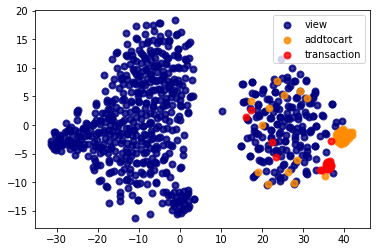

In [33]:
y_true = np.argmax(y,axis=1)

plt.figure()
colors = ['navy', 'darkorange', 'red']
lw = 2
target_names = action_to_idx.keys()

#original points
for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(embeddings_reduced[y_true == i, 0], embeddings_reduced[y_true == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

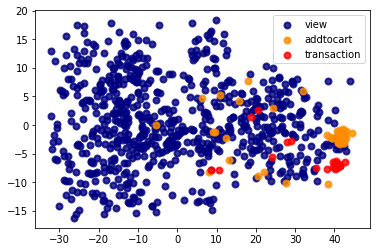

In [34]:
embeddings_reduced2 = tsne.fit_transform(embeddings2)
plt.figure()
colors = ['navy', 'darkorange', 'red']
lw = 2
target_names = action_to_idx.keys()

#original points
for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(embeddings_reduced2[y_true == i, 0], embeddings_reduced2[y_true == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

In [140]:
embeddings_reduced3 = tsne.fit_transform(embeddings3)
plt.figure()
colors = ['navy', 'darkorange', 'red']
lw = 2
target_names = action_to_idx.keys()

#original points
for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(embeddings_reduced3[y_true == i, 0], embeddings_reduced3[y_true == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

IndexError: ignored

<Figure size 432x288 with 0 Axes>

No handles with labels found to put in legend.


(25714, 2)

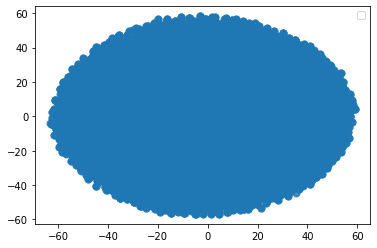

In [162]:
y_true = np.argmax(y,axis=1)
# for color, i, target_name in zip(colors, [0, 1,2], target_names):
plt.scatter(embeddings_reduced3[:, 0], embeddings_reduced3[:, 1], alpha=.8, lw=lw)
plt.legend(loc='best', shadow=False, scatterpoints=1)

embeddings_reduced3.shape

In [0]:
pickle.dump( visitor_sessions, bz2.BZ2File('visitor_sessions.pkl', 'w') )
pickle.dump( embeddings3, bz2.BZ2File('embeddings3.pkl', 'w') )

To Dos


*   [ ] visualize sequence of user actions
*   [x] create proper train and test sets
*   [ ] incorporate item features into model
* [x] check LSTM is embedding users correctly
     * [x] create data set by user sessions






